In [10]:
%matplotlib inline
import sys
BIN = '/Users/nallenallis/Documents/LTH/Exjobb/AE-Compression-pytorch-master2'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib as mpl

#from fastai import data_block, basic_train, basic_data
from fastai import learner
from fastai.data import core
from sklearn.preprocessing import StandardScaler

In [11]:
from HEPAutoencoders.nn_utils import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [12]:
## Importing data (.pkl to pandas) ##
train = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/AE-Compression-pytorch-master2/examples/phenoML/test_data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/AE-Compression-pytorch-master2/examples/phenoML/test_data/all_jets_test_4D_100_percent.pkl')

train = train[:200]
print(train.shape)
print(test.shape)
test.head()

(200, 4)
(27945, 4)


,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


In [13]:
## Removing m<0
m = test[test['m'] < 0]
test = test[test['m'] > 0]
m.head(n=5)

,m,pt,phi,eta
22052,-0.023060,40007.324219,-1.114247,-4.619285
75826,-0.015843,73372.484375,-0.052096,3.491533
9046,-0.023041,61983.359375,-0.603030,3.953503
33647,-0.016038,30377.523438,-1.315213,-4.467676
82778,-0.045315,146861.218750,2.322524,-3.736695


In [14]:
## Custom normalization of variables ## 
variables = test.keys()
test['m'] = test['m'] / 1000.0
test['pt'] = test['pt'] / 1000.0

test['eta'] = test['eta'] / 5
test['phi'] = test['phi'] / 3
test['m'] = np.log10(test['m']) 
test['pt'] = np.log10(test['pt'])

test.head()

,m,pt,phi,eta
85972,0.697555,1.376542,0.654052,-0.011906
38742,0.735221,1.340084,0.345137,0.146869
128711,0.719282,1.391079,-0.373685,0.165770
28751,1.149873,2.307733,0.108068,-0.514222
131358,0.524374,1.396152,0.131777,0.288014


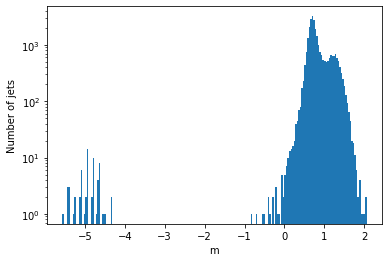

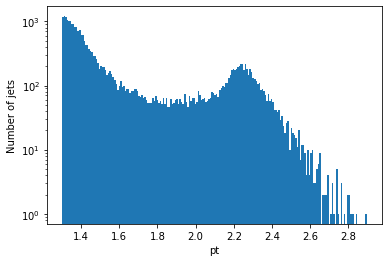

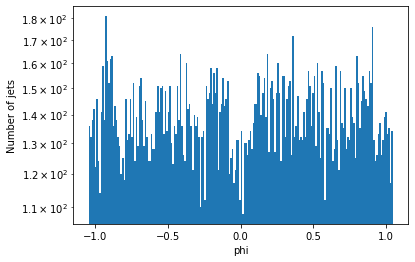

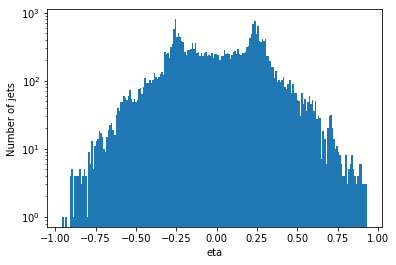

In [15]:
## Plotting data ##
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

logy = True
plot_all(test, logy)

In [16]:
## Packing data for network ##
train_ds = TensorDataset(torch.tensor(train.values, dtype=torch.float), torch.tensor(train.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test.values, dtype=torch.float), torch.tensor(test.values, dtype=torch.float))

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)

dls = core.DataLoaders(train_dl, valid_dl)
#db = basic_data.DataBunch(train_dl, valid_dl)

In [17]:
## Model set-up
nodes = [4, 400, 400, 200, 3, 200, 400, 400, 4]
model = AE_bn_LeakyReLU(nodes)
model.train() # Sets the module in training mode

AE_bn_LeakyReLU(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=200, out_features=3, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, t

In [18]:
## Network set-up ##
loss_func = nn.MSELoss()
wd = 1e-2 # Default weight decay

#from fastai.callbacks import ActivationStats
#learner = basic_train.Learner(data=db, model=model, wd=wd, loss_func=loss_func, callback_fns=ActivationStats, true_wd=True)
#learn = learner.Learner([train_dl, valid_dl], model=model, wd=wd, loss_func=loss_func)
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func)

learn.load('best_nn_utils_bs8192_lr1e-04_wd1e-02')

#### Calculate MSE on the test-set

In [19]:
learn.validate()

(#1) [1.7660138607025146]

In [20]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    #df['E'] = 10**df['E']
    df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)

In [21]:
unnormalized_data_df.head()

,m,pt,phi,eta
0,4.983730,23.798069,1.962157,-0.059532
1,5.435273,21.881870,1.035412,0.734343
2,5.239408,24.608135,-1.121055,0.828848
3,14.121243,203.110931,0.324205,-2.571108
4,3.344826,24.897293,0.395331,1.440069


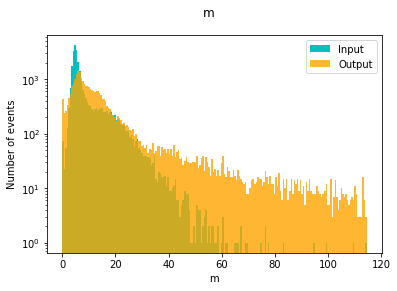

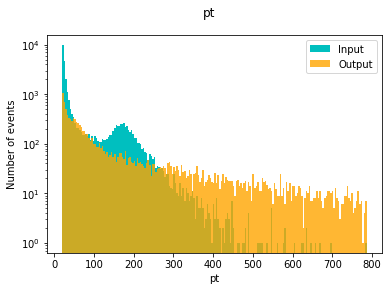

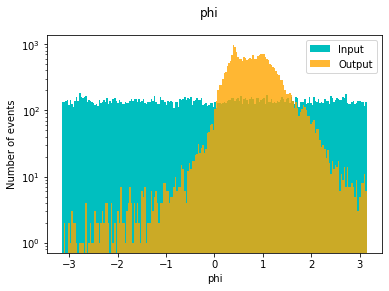

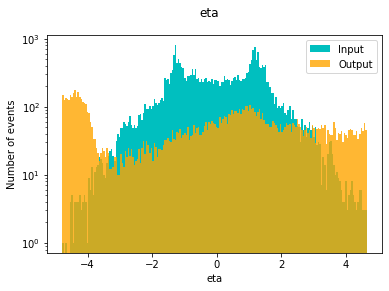

In [22]:
import os
data = data_df.values
pred = pred_df.values

save = True
save_dir = 'AE_PhenoML_4D-3D_400ReLU_BN_MSE_Custom-norm'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [23]:
data = unnormalized_data_df
pred = unnormalized_pred_df

residuals = (pred - data)  # / data
# diff = (pred - data)

diff_list = ['phi',
             'eta',
             ]

rel_diff_list = ['m',
                 'pt']

for var in rel_diff_list:
    residuals[var] = residuals[var] / data[var]
res_df = pd.DataFrame(residuals, columns=test.columns)


lab_dict = {
    'pt': '$(p_{T,out} - p_{T,in}) / p_{T,in}$',
    'eta': '$\eta_{out} - \eta_{in}$ [rad]',
    'phi': '$\phi_{out} - \phi_{in}$ [rad]',
    'm': '$(m_{out} - m_{in}) / m_{in}$',
}


# Compute correlations
corr = res_df.corr()

In [24]:
residuals['m'][residuals['m'] == -np.inf] = 0
residuals['m'][residuals['m'] == np.inf] = 0

In [25]:
np.sum(data['m'] == 0)

0

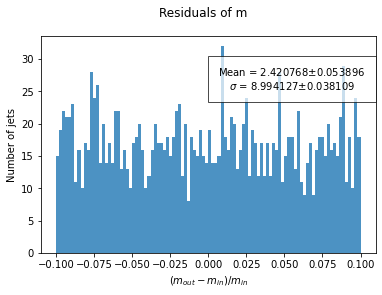

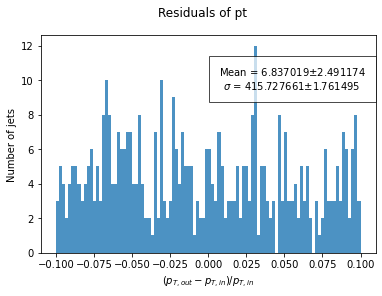

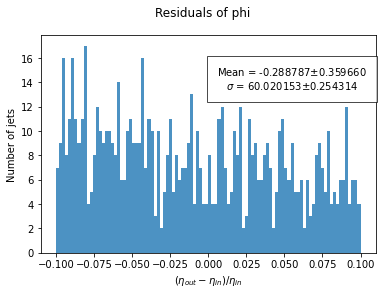

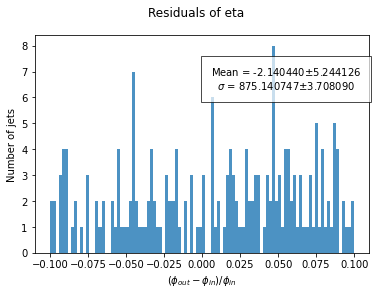

In [26]:
from HEPAutoencoders import utils
from scipy import stats

residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        ]
# residuals = (pred_df - data_df) #/ data
rang = (-0.1, 0.1)
# range=None

# indx = data['m']!=0
# data['m'] = data['m'][indx]
# data['m'][np.abs(data['m']) < 1e-3] = 1e-3
# pred['m'] = pred['m'][indx]

r = (pred - data)
rel_diff_list = ['m',
                 'pt',
                 'eta',
                 'phi']

# r['m'][np.abs(r['m']) < 1e-3] = 1e-3

for var in rel_diff_list:
    r[var] = r[var] / data[var]

# residuals['m'][residuals['m'] == -np.inf] = 0
# residuals['m'][residuals['m'] == np.inf] = 0

r = r.values
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        r[:, kk], label='Residuals', linestyle=line_style[0], alpha=0.8, bins=100, range=rang)
    plt.suptitle('Residuals of %s' % test.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
#     ms.sciy()
#     plt.yscale('log')
    std = np.nanstd(r[:, kk])
    std_err = np.nanstd(r[:, kk], ddof=0) / np.sqrt(2 * len(r[:, kk]))
    mean = np.nanmean(r[:, kk])
    sem = stats.sem(r[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
    fig_name = 'Residual_%s' % train.columns[kk]
    plt.savefig(os.path.join(save_dir, fig_name))

FileNotFoundError: [Errno 2] No such file or directory: '/home/honey/cern/HEPAutoencoders/my_matplotlib_rcparams'

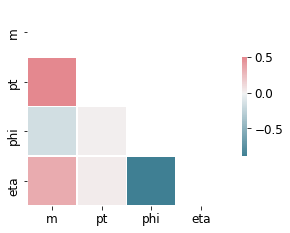

In [286]:
import seaborn as sns

save=True

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# cmap = 'RdBu'
# Plot heatmap
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.subplots_adjust(left=.23, bottom=.30, top=.99, right=.99)
mpl.rc_file('/home/honey/cern/HEPAutoencoders/my_matplotlib_rcparams')
if save:
    fig_name = 'corr_matrix.png'
    plt.savefig(os.path.join(save_dir, fig_name))

if not save:
    plt.show()

In [ ]:
from corner import corner
latent_dim = 20
save = True

corner_groups = [
    ['pt', 'eta', 'phi', 'm']
]

for i_group, group in enumerate(corner_groups):
    group_df = residuals[group]
    
    # Compute correlations
    corr = group_df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    # Plot heatmap
    mpl.rcParams['xtick.labelsize'] = 12
    mpl.rcParams['ytick.labelsize'] = 12
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.subplots_adjust(left=.23, bottom=.30, top=.99, right=.99)

    label_kwargs = {'fontsize': 20, 'rotation': -15, 'ha': 'left'}
    title_kwargs = {"fontsize": 8}
    mpl.rcParams['lines.linewidth'] = 1
    mpl.rcParams['xtick.labelsize'] = 10
    mpl.rcParams['ytick.labelsize'] = 10
    group_arr = group_df.values
    qs = np.quantile(group_arr, q=[.0025, .9925], axis=0)
    ndim = qs.shape[1]

    ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]

    ranges = [(-0.02, 0.02)]*ndim #Fixed-range
    figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                    bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                    show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                    levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

    # # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    # Loop over the diagonal
    linecol = 'r'
    linstyl = 'dashed'

    for xi in range(ndim):
        ax = axes[0, xi]
        # Set xlabel coords
        ax.xaxis.set_label_coords(.5, -.8)
    for yi in range(ndim):
        ax = axes[yi, 0]
        # Set ylabel coords
        ax.yaxis.set_label_coords(-.4, .5)
        ax.set_ylabel(ax.get_ylabel(), rotation=80, ha='right')
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            # Set face color according to correlation
            ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
    cax = figure.add_axes([.87, .4, .04, 0.55])
    cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
    cbar.ax.set_ylabel('Correlation', fontsize=20)

    if i_group == 6:
        plt.subplots_adjust(left=0.13, bottom=0.21, right=.82)
    else:
        plt.subplots_adjust(left=0.13, bottom=0.20, right=.83)
    if save:
        fig_name = 'slide_corner_%d_group%d' % (20, i_group)
        plt.savefig(os.path.join(save_dir, fig_name))

if not save:
    plt.show()